In [1]:
%matplotlib inline


# Vocal separation


This notebook demonstrates a simple technique for separating vocals (and
other sporadic foreground signals) from accompanying instrumentation.

This is based on the "REPET-SIM" method of `Rafii and Pardo, 2012
<http://www.cs.northwestern.edu/~zra446/doc/Rafii-Pardo%20-%20Music-Voice%20Separation%20using%20the%20Similarity%20Matrix%20-%20ISMIR%202012.pdf>`_, but includes a couple of modifications and extensions:

    - FFT windows overlap by 1/4, instead of 1/2
    - Non-local filtering is converted into a soft mask by Wiener filtering.
      This is similar in spirit to the soft-masking method used by `Fitzgerald, 2012
      <http://arrow.dit.ie/cgi/viewcontent.cgi?article=1086&context=argcon>`_,
      but is a bit more numerically stable in practice.



In [45]:
# Code source: Brian McFee
# License: ISC

##################
# Standard imports
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import librosa.display
from pathlib import Path
from tqdm import tqdm

In [3]:
img_dir = Path('./gen_img')
if not os.path.exists(img_dir):
    os.mkdir(img_dir)

Load an example with vocals.



In [4]:
y, sr = librosa.load('out2.mp3', duration=None)


# And compute the spectrogram magnitude and phase

S_full, phase = librosa.magphase(librosa.stft(y))

In [5]:
y[20:35]

array([-0.0002731 , -0.00043456, -0.00082417, -0.00124113, -0.00174721,
       -0.00247124, -0.00300579, -0.00266128, -0.00150881, -0.00050506,
       -0.00036475, -0.00056087,  0.00018259,  0.00221652,  0.00455707],
      dtype=float32)

### Make Audio Chunks 

In [6]:
len(y)
print(sr)
print(len(y)/sr)

22050
640.7890249433107


In [7]:
y[5*sr:15*sr]


array([ 0.03485449,  0.03716198,  0.0371261 , ..., -0.02310218,
       -0.02093078, -0.01632755], dtype=float32)

In [8]:
print(y.min())
print(y.max())

-0.60581756
0.69416


In [24]:
def make_chunks(audio):
    
    checkpoints = [0] 
    
    checkpoint_flag = 0          # 0 means off 
    
    for idx,amp in enumerate(audio):
        
        if amp == 0.0 and checkpoint_flag == 0:
            checkpoint_flag = 1
#             print(amp,",",idx/sr,end=',')
            checkpoints.append(idx/sr)
#             print("\n")
        
        elif amp == 0.0 and checkpoint_flag == 1:
            checkpoint_flag = 1
        
        elif amp!=0 and checkpoint_flag == 1:
            checkpoint_flag = 0
#             print(amp,",",idx/sr,end=',')
            checkpoints.append(idx/sr)
#             print()
        
#     return checkpoints
    print(checkpoints)
    
    
    ## Making tuples for storing chunks
    prev = 0
    chunks = []
    for checkpoint in checkpoints:
        if not checkpoint - prev > 2: continue
        chunks.append((prev,checkpoint))
        prev = checkpoint
    
    return checkpoints,chunks

In [28]:
_,audio_chunks = make_chunks(y)

[0, 9.539138321995464, 9.540589569160998, 32.10829931972789, 32.21115646258503, 32.30009070294785, 32.403083900226754, 32.49147392290249, 32.53501133786848, 32.60040816326531, 32.799455782312926, 66.00775510204082, 66.02739229024944, 66.28390022675737, 66.3273469387755, 66.51233560090704, 66.53918367346938, 66.58353741496599, 66.66349206349206, 66.7887074829932, 66.81832199546486, 66.87891156462585, 66.879410430839, 66.90394557823129, 66.92748299319727, 67.24349206349207, 67.30498866213152, 67.35174603174603, 67.36716553287982, 67.47977324263039, 67.61904761904762, 67.71328798185941, 67.72412698412698, 67.84412698412699, 67.97120181405896, 112.94145124716553, 113.08934240362812, 126.03351473922902, 126.0574149659864, 126.24662131519274, 126.25537414965986, 126.4055328798186, 126.4995918367347, 126.83628117913833, 126.8671201814059, 155.2868934240363, 155.35478458049886, 155.77115646258503, 155.77260770975056, 155.77950113378685, 155.80072562358276, 155.85151927437641, 155.9312018140589

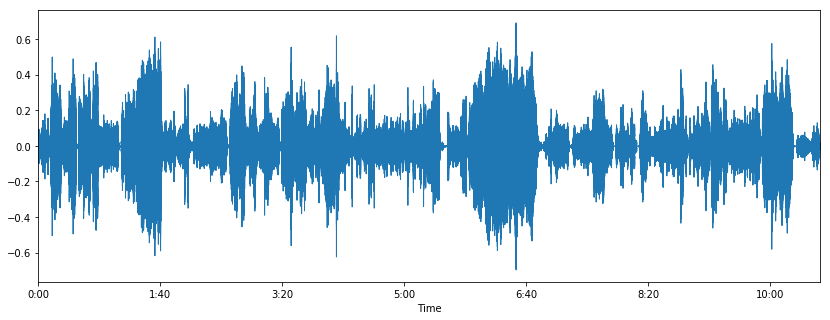

In [26]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

## Play Audio

In [33]:
import IPython.display as ipd
def play_aud(start,end,content,sr,save = False):
    ipd.Audio(y[int(start*sr):int(end*sr)], rate=sr) # load a NumPy array
    
    if save==True:
        librosa.output.write_wav('tone_{}to{}.wav'.format(start,end), x, sr)


        

In [34]:
for aud_chunk_start,aud_chunk_end in audio_chunks:
    play_aud(aud_chunk_start,aud_chunk_end,y,sr)

In [37]:
audio_chunks[0]

(0, 9.539138321995464)

In [38]:
ipd.Audio(y[int(audio_chunks[0][0]*sr):int(audio_chunks[0][1]*sr)], rate=sr) # load a NumPy array

## Plot audio chunks

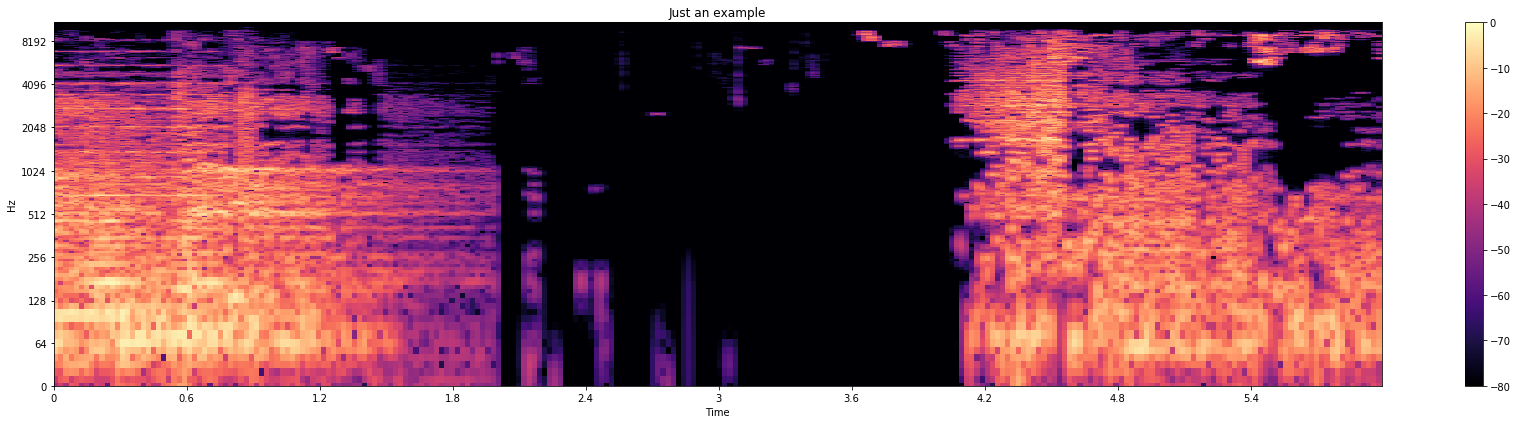

In [14]:
idx = slice(*librosa.time_to_frames([64, 70], sr=sr))
plt.figure(figsize=(24, 6))
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.title('Just an example')
plt.tight_layout()

Plot a 5-second slice of the spectrum



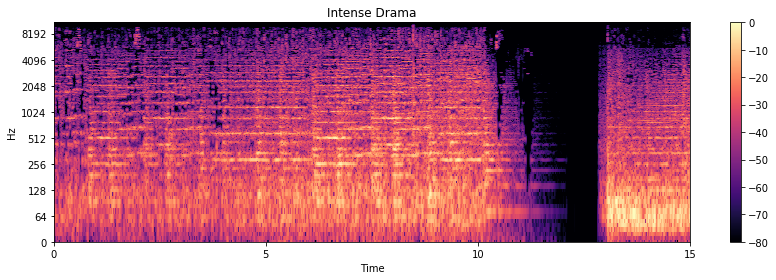

In [37]:
idx = slice(*librosa.time_to_frames([20, 35], sr=sr))
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.title('Intense Drama')
plt.tight_layout()

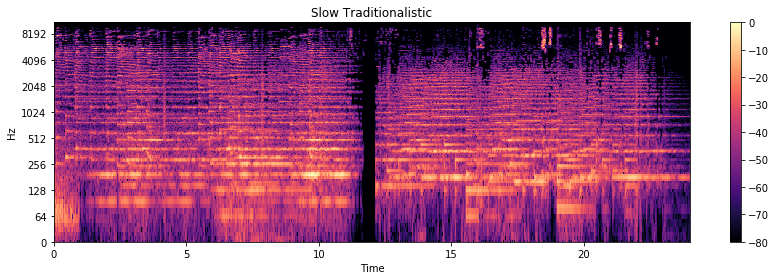

In [38]:
idx = slice(*librosa.time_to_frames([101, 125], sr=sr))
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.title('Slow Traditionalistic')
plt.tight_layout()

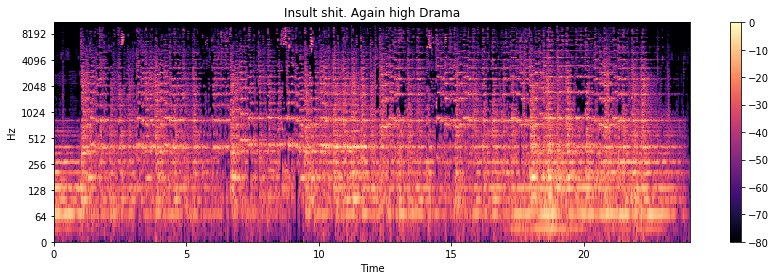

In [40]:
idx = slice(*librosa.time_to_frames([131, 155], sr=sr))
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.title('Insult shit. Again high Drama')
plt.tight_layout()

In [50]:
import time

### Downloading images

In [104]:
import pylab

def save_images(S_full,sr,strtend_list,filesavename='test'):
    
    pylab.axis('off') # no axis

    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge

    
    for indx,(start,end) in enumerate(strtend_list):
        print(start,end)
        start=int(start)
        end = int(end)
        idx = slice(*librosa.time_to_frames([start, end], sr=sr))
        librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                                 y_axis='log', x_axis='time', sr=sr)
        
        filnamenow = "{}_{}to{}.jpg".format(filesavename,start,end)
        
        filnamefldr = Path(img_dir/os.path.basename(filnamenow))
        
        if not filnamefldr.exists():
            filnamefldr.mkdir()          # Storing every image with its own name
        
        pylab.savefig(filnamefldr/filnamenow, bbox_inches=None, pad_inches=0)
            
    pylab.close()
    
    
    

# pylab.axis('off') # no axis

# pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge

# idx = slice(*librosa.time_to_frames([20, 120], sr=sr))
# # plt.figure(figsize=(12, 4))
# librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
#                          y_axis='log', x_axis='time', sr=sr)


# save_path='test.jpg'
# pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
# pylab.close()


In [105]:
save_images(S_full,sr,audio_chunks)

0 9.539138321995464
9.539138321995464 32.10829931972789
32.10829931972789 66.00775510204082
66.00775510204082 112.94145124716553
112.94145124716553 126.03351473922902
126.03351473922902 155.2868934240363
155.2868934240363 198.76380952380953
198.76380952380953 332.33514739229025
332.33514739229025 334.39954648526077
334.39954648526077 437.2037188208617
437.2037188208617 471.33206349206347
471.33206349206347 473.46907029478456
473.46907029478456 490.25573696145125
490.25573696145125 492.8603628117914
492.8603628117914 533.5283900226757
533.5283900226757 619.0755102040816
619.0755102040816 621.5312018140589
621.5312018140589 640.7889795918368


In [87]:
from PIL import Image
ata = Image.open('./gen_img/test_0to9.jpg')

(432, 288)

0-9 Some tensed BGM
9-32 Same tensed BGM

The wiggly lines above are due to the vocal component.
Our goal is to separate them from the accompanying
instrumentation.




In [28]:
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

The raw filter output can be used as a mask,
but it sounds better if we use soft-masking.



In [29]:
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

Plot the same slice, but separated into its foreground and background



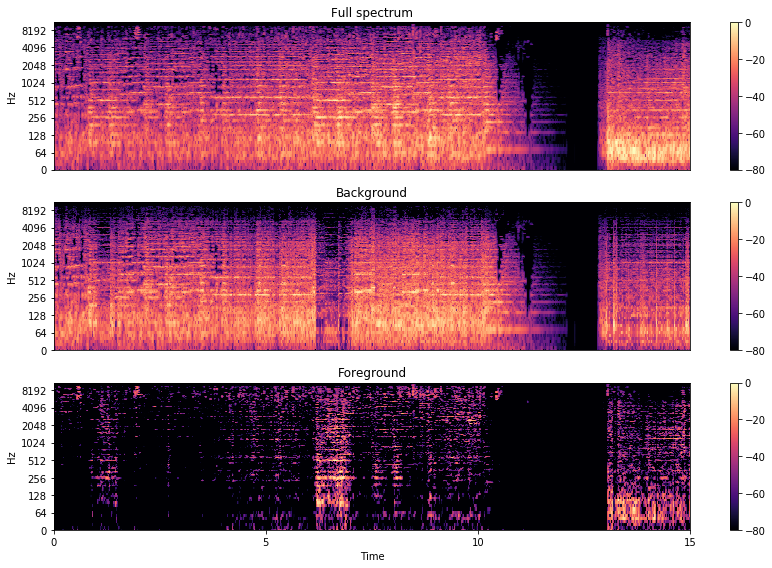

In [30]:
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

In [43]:
# librosa.output.write_wav('librosa-check.wav', y[30*sr:sr*35], sr)
librosa.output.write_wav('librosa-check.wav', S_background , sr)

In [47]:
len(y)

14129398

In [48]:
sr

22050

In [49]:
len(y)/sr

640.7890249433107

In [42]:
len(S_background)

1025

In [50]:
len(S_background)

1025